# Part 1

In [2]:
import pymc as pm; 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [56]:
data = pd.read_csv('hw5_data_apple_quality.csv')
data.dropna(inplace = True)
data.drop(['A_id','Quality'], axis = 1, inplace = True)
data['Acidity'] = data['Acidity'].astype(float)

X = data.drop('Acidity', axis=1)
X = X.assign(Intercept=1)
ys = data['Acidity']
p = X.shape[1]
X.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Intercept
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,1
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,1
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,1


array([[<Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Sweetness'}>],
       [<Axes: title={'center': 'Crunchiness'}>,
        <Axes: title={'center': 'Juiciness'}>,
        <Axes: title={'center': 'Ripeness'}>],
       [<Axes: title={'center': 'Acidity'}>, <Axes: >, <Axes: >]],
      dtype=object)

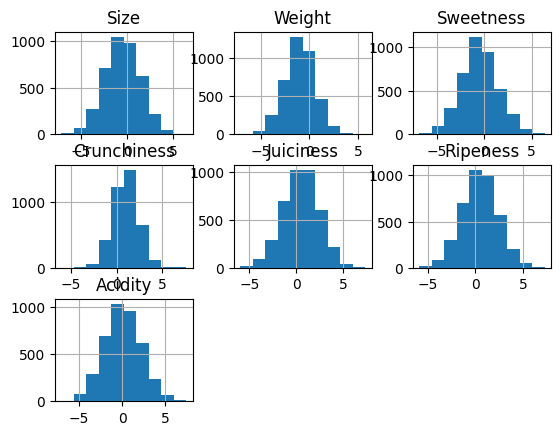

In [13]:
data.hist()



In [58]:

labels = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Intercept']
coords = {"coeffs": labels}

with pm.Model(coords=coords) as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros(p), cov=np.eye(p), dims='coeffs')
    sigma = sigma = pm.HalfCauchy('sigma', beta=10)
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=ys)
with MLR:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[Size],0.260,0.018,0.226,0.294,0.000,0.000,3567.0,3443.0,1.0
betas[Weight],0.129,0.022,0.085,0.170,0.000,0.000,3798.0,2758.0,1.0
betas[Sweetness],0.151,0.019,0.114,0.187,0.000,0.000,3821.0,3053.0,1.0
betas[Crunchiness],0.152,0.024,0.109,0.199,0.000,0.000,4612.0,3067.0,1.0
betas[Juiciness],0.294,0.017,0.263,0.326,0.000,0.000,5103.0,3388.0,1.0
betas[Ripeness],-0.070,0.020,-0.108,-0.032,0.000,0.000,3711.0,2876.0,1.0
betas[Intercept],0.140,0.049,0.045,0.232,0.001,0.001,4035.0,3090.0,1.0


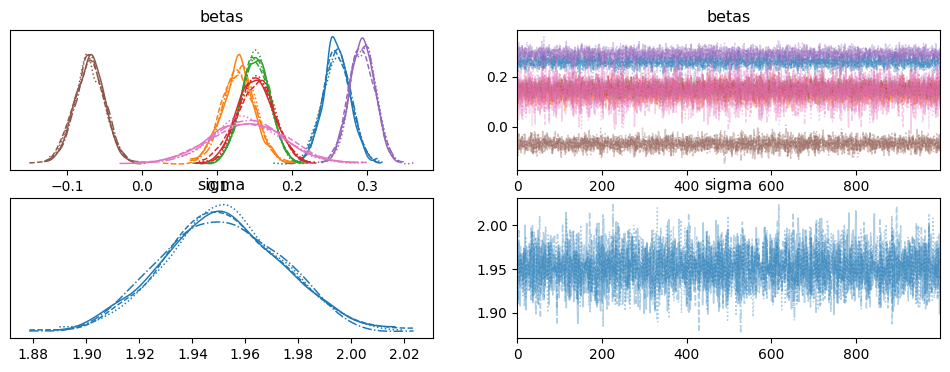

In [60]:
import arviz as az

# Trace plots
az.plot_trace(idata)

# Coefficient table
summary = az.summary(idata, var_names=['betas'])
summary


# Part 2

### Q1

Given $\Sigma = \sigma^2 I$, we have $\Sigma^{-1} = \frac{1}{\sigma^2} I$. Substituting into the posterior distribution for $\mathbf{\beta}$, we have:  

$$
p(\boldsymbol \beta |\sigma^2, \mathbf{X},\mathbf{y}) = \mathcal{MVN}\left( \text{E}[\boldsymbol \beta | \sigma^2, \mathbf{X},\mathbf{y}] = \left[\frac{1}{\sigma^2}\mathbf{X}^{\top}\mathbf{X}  + \boldsymbol \Sigma_\beta^{-1} \right]^{-1}\left( \frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{y} + \boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta_0 \right), \text{Cov}[\boldsymbol \beta | \sigma^2, \mathbf{X},\mathbf{y}] = \left[\frac{1}{\sigma^2}\mathbf{X}^{\top} \mathbf{X}  + \boldsymbol \Sigma_\beta^{-1} \right]^{-1} \right)
$$


### Q2

The expectation of $\beta$ becomes:

$$
E[\boldsymbol \beta | \sigma^2, \mathbf{X}, \mathbf{y}] = \left[\frac{1}{\sigma^2}\mathbf{X}^{\top}\mathbf{X}  + \boldsymbol \Sigma_\beta^{-1} \right]^{-1}\left( \frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{y} + \boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta_0 \right)
$$


### Q3
For $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$ to simplify to $(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$, we need to set the precision of the prior, $\boldsymbol \Sigma_\beta^{-1} $, to 0 effectively removing the prior's influence from the posterior estimation. Conceptually, this corresponds to a non-informative or flat prior.

Substitute $\boldsymbol \Sigma_\beta^{-1} = 0$ into the equation:

$$\begin{align}
E[\boldsymbol \beta | \sigma^2, \mathbf{X}, \mathbf{y}] &= \left[\frac{1}{\sigma^2}\mathbf{X}^{\top}\mathbf{X} + 0 \right]^{-1}\left( \frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{y} + 0 \right)\\
E[\boldsymbol \beta | \sigma^2, \mathbf{X}, \mathbf{y}] &= \left[\frac{1}{\sigma^2}\mathbf{X}^{\top}\mathbf{X} \right]^{-1} \left( \frac{1}{\sigma^2}\mathbf{X}^\top\mathbf{y} \right)\\
E[\boldsymbol \beta | \sigma^2, \mathbf{X}, \mathbf{y}] &= (\mathbf{X}^{\top}\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}
\end{align}$$



### Q4
The conditions to make the expected value of the predicted outcomes $\hat{y}$ equal to this expression are the same as in question 3 because $\hat{y}$ directly depends on $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$. 

$$\begin{align}
E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] &=\mathbf{X}E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]\\
&= \mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}
\end{align}
$$


### Q5

$$\text{Var}[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \left[\frac{1}{\sigma^2}\mathbf{X}^{\top} \mathbf{X}  + \boldsymbol \Sigma_\beta^{-1} \right]^{-1}$$

# Part 3